In this project, we will attempt to classify authors by their respective book texts. This will be accomplished through applying natural language processing (NLP) and unsupervised learning algorithms on 100 science fiction novels, with 17 different authors, gathered from Project Gutenberg's website. 

We will be focusing primarily on K-Means clustering to make our groupings, but we will also be introducing hierarchical and T-distributed stochastic neighbor embedding when visualizing our clusters.

## Project Summary

### Project Type: Unsupervised Learning Classification

#### Data: 

##### (y) Authors:
Poul Anderson (books: 9), Pauline Ashwell (books: 1), C.C. Beck (books: 1), Miles J. Breuer (books: 1), Bradner Buckner (books: 1), Algis Budrys (books: 6), Mark Clifton (books: 8), Alan Cogan (books: 2), Lester Del Rey (books: 10), H.B. Fyfe (books: 10), Randall Garrett (books: 10), Fritz Leiber (books: 10), Mack Reynolds (books: 10), John Sentry (books: 1), H.G. Wells (books: 10), Robert Moore Williams (books: 9), Arthur Leo Zagat (books: 1)

##### (X) Extracted Book Texts (Bag of Words, Inverse Document Frequency, and Term-frequency weights (tfidf))

### Unsupervised Learning Techniques:

- KMeans Clustering
- Hierarchical Clustering
- T-distributed stochastic neighbor embedding (TSNE)

### Classification Techniques:

- Support Vector Classifier (SVC)
- Logistic Regression
- Random Forest Classifier
- XGBoost

Book Source: https://www.gutenberg.org/wiki/Science_Fiction_(Bookshelf)

## Preprocessing

In [270]:
import nltk
import re
import pandas as pd
import numpy as np
import books_files as books
from urllib import request
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

In [271]:
def text_cleaner(text_data):
    '''
    Cleaning Book Texts:
    1. Remove non-words from texts (i.e. punctuations,dash,etc.)
    2. Convert text to lowercase letters
    3. Create list of words from text, split by spacing
    4. Extract non-stopwords and lemmatize these words using WordNetLemmatizer()
    5. Combine words in list back into text format
    
    Note: stopwords are words that are used often but do not provide much informational value (i.e. the, and, of)
    '''
    text = re.sub("[^a-zA-Z]",' ',text_data)
    text = text.lower()
    text = text.split()
    lmz = WordNetLemmatizer()
    text = [lmz.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

def strip_proper_nouns(text_data):
    no_punc = re.sub("[^a-zA-Z]",' ',text_data)
    tagged = pos_tag(no_punc.split())
    non_propernouns = [word for word,pos in tagged if pos != "NNP" and pos != "NNPS"]
    text = ' '.join(non_propernouns)
    return text

In [272]:
from io import StringIO

book_text = []
authors = []

# access key,value pair in books.py url dictionary (url_dict)
for k,v in books.url_dict.items():
    for url in v:
        response = request.urlopen(url) # opens url HTTP containing text from project gutenberg website
        raw = response.read().decode('utf8') # decodes the response encoding from url 
        s = StringIO(raw) # writes string as file
        
        # take only the relevant text from book, removes gutenberg instructions & other irrelevant text
        text_lines = [] 
        for i,line in enumerate(s):
            text_lines.append(line)
            if "START OF THIS PROJECT" in line:
                start_index = (i+1)
            if "END OF THIS PROJECT" in line:
                end_index = i
                
        book_text.append(' '.join(text_lines[start_index:end_index]))
        authors.append(k)

In [273]:
print("Total number of books: ",len(book_text))
print("\nTotal number of authors: ",len(set(authors)))

Total number of books:  100

Total number of authors:  17


In [274]:
# create dataframe with book texts and authors

text_df = pd.DataFrame()
text_df["Text"] = book_text
text_df["Author"] = authors
text_df["Author_ID"] = text_df["Author"].factorize()[0] # convert author categorical variables to numerical labels
text_df.head(3)

,Text,Author,Author_ID
0,"\r\n \r\n \r\n \r\n Produced by Greg Weeks, Ma...",Anderson,0
1,\r\n \r\n \r\n \r\n Produced by Sankar Viswana...,Anderson,0
2,\r\n \r\n \r\n \r\n Produced by Sankar Viswana...,Anderson,0


In [275]:
# create bag of words using text_cleaner function to filter texts

corpus = []
for text in book_text:
    no_p_nouns = strip_proper_nouns(text)
    clean_text = text_cleaner(no_p_nouns)
    corpus.append(clean_text)

In [276]:
'''
Need to weight the frequency of words (count) in a document so that words that occur less often but have
potentially more relevant information are given higher weights than words that occur more frequently. 
We will use TfidfVectorizerto create a sparse vector space model that will contain the weights of all 
the words contained in the texts.
''' 
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(
    max_df = 0.5, # drop words that occur in more than half the texts
    min_df = 2, # only use words that appear at least twice
    # re-iterating cleaning methods in case text_cleaner() missed any values
    stop_words = "english",
    lowercase = True,
    use_idf = True,
    norm = u'l2', # normalize term vectors (longer & shorter text are treated equally)
    smooth_idf = True # adds 1 to all document frequencies as if an extra document contains every term in collection exactly once. Prevents zero divisions.
)

In [277]:
X = tfidf_v.fit_transform(corpus)
y = text_df.iloc[:,2].values

In [278]:
# create train & test folds to prevent overfitting
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [279]:
print("X training set has {} rows and {} columns".format(X_train.shape[0],X_train.shape[1]))
print("X test set has {} rows and {} columns".format(X_test.shape[0],X_test.shape[1]))

X training set has 75 rows and 16727 columns
X test set has 25 rows and 16727 columns


## Building Clusters

The clusters will be built on the premise of how similar the texts, from the different books, are to each other. The similarity is measured using cosine similarity that, when applied to the tfidf matrix, will calculate the cosine angle between two different texts. The cosine angle can be used to find the cosine distance of the texts that can then be used for plotting on a 2-dimensional (euclidean) plane. The closer the cosine distance is to 0, the more similar the texts are to one another. 

In [280]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(X_train)

### KMeans Clustering

Since we are interested in creating clusters based on distances between feature data points, then we can try using the KMeans clustering algorithm. KMeans establishes "k" number of centroids, or center points, and then groups data points according to the distance from the centroids. A point is placed in a cluster if it's closer to that cluster's centroid than any other centroid.

To determine the optimal number of "k" centroids, we will use the elbow method. Going back to KMeans, as the number of "k" centroids increases, the distance between centroids and other data points decreases. Therefore, increasing "k" will always decrease the sum of squared errors (SSE), or the distance between data points and their mean cluster centroid. This "inertia" will continue to decrease as "k" increases until it eventually reaches 0 where each datapoint is its own cluster. We ideally want to find a small value of "k" that still has a low inertia, and the "elbow" in the elbow method plot indicates the point at which there is diminishing returns by increasing "k".

In [281]:
from sklearn.cluster import KMeans
wcss = [] # list of interia values at each "k" cluster trial (within cluster sum of squared errors, wcss)
n_clusters = list(range(2,11)) # finding optimal "k" clusters out of 10 possible clusters trials
for i in n_clusters:
    kmeans = KMeans(n_clusters=i,random_state=42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

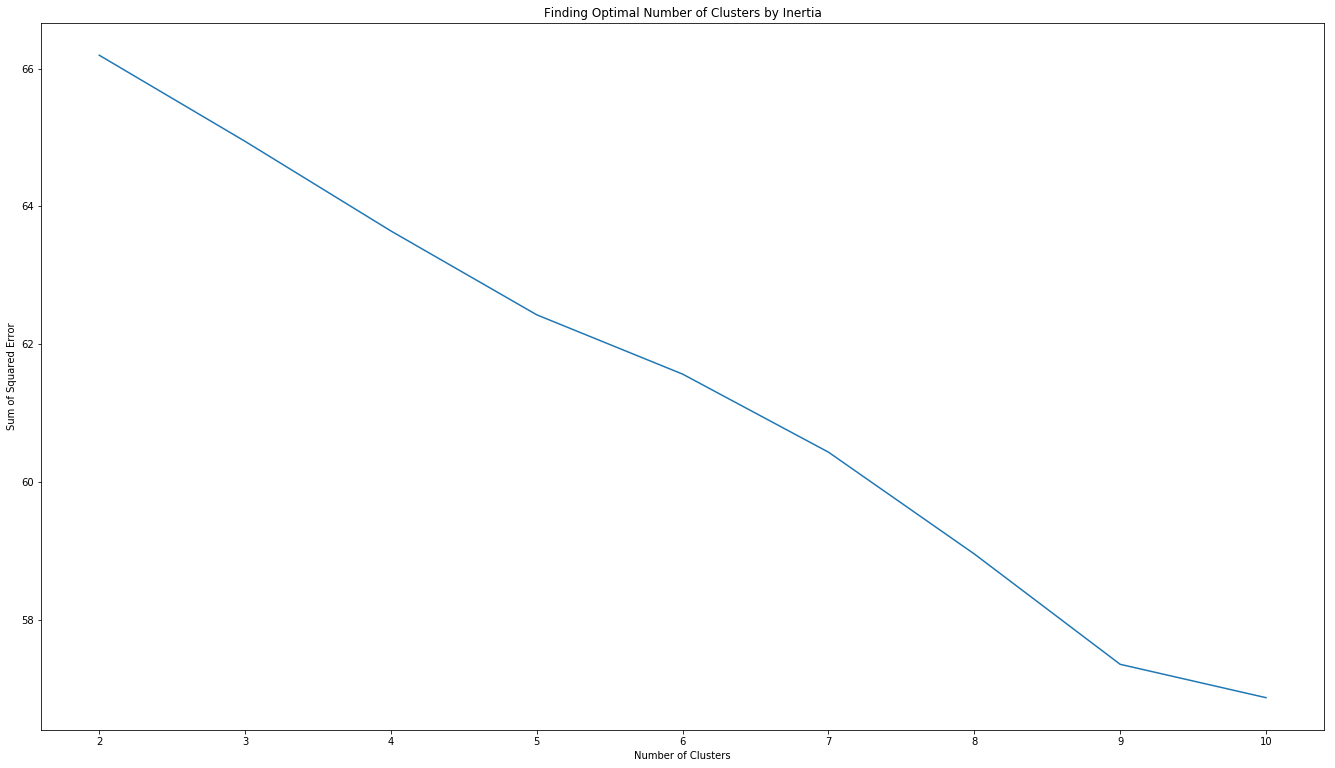

In [282]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (23,13)
plt.plot(n_clusters,wcss)
plt.title("Finding Optimal Number of Clusters by Inertia")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Error")
plt.xticks(n_clusters)
plt.show()

There appears to be an elbow at 5 clusters. The plot itself doesn't appear to be a curve which makes using the elbow method very difficult to distinguish the optimal number of clusters. Lets try a different technique...

We can try using silhouette scores to find the optimal number of clusters. The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. High scores (closer to 1) indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. We are looking for relatively high average silhouette scores and evenly distributed cluster sizes.  

In [283]:
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.cm as cm

def graph_sil_score(distance):

    fig,ax = plt.subplots(nrows=3,ncols=3)
    row = 0
    col = 0

    for i in n_clusters:
        ax[row,col].set_xlim([-0.1,1])
        ax[row,col].set_ylim([0,X_train.shape[0] + (i+1)*10])

        clusterer = KMeans(n_clusters=i,random_state=42)
        cluster_labels = clusterer.fit_predict(X_train)

        sil_avg = silhouette_score(dist,cluster_labels,metric="precomputed")

        sample_sil_values = silhouette_samples(dist,cluster_labels,metric="precomputed")

        y_lower = 10
        for cluster in range(i):
            ith_cluster_sil_values = sample_sil_values[cluster_labels == cluster]
            ith_cluster_sil_values.sort()
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(cluster)/i)

            ax[row,col].fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_sil_values,facecolor=color,edgecolor=color,alpha=0.7)
            ax[row,col].text(-0.05,y_lower + 0.5 * size_cluster_i,str(cluster))

            y_lower = y_upper + 10

        ax[row,col].set_title("For n_clusters = {}, the average silhouette_score is: {}".format(i,sil_avg))
        ax[row,col].set_xlabel("The silhouette coefficient values")
        ax[row,col].set_ylabel("Clusters")

        # vertical line for average silhouette score of all values
        ax[row,col].axvline(x=sil_avg,color="red",linestyle="--")
        ax[row,col].set_yticks([])
        ax[row,col].set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])

        col+=1
        if col == 3:
            col = 0
            row += 1

    fig.tight_layout()
    plt.show()

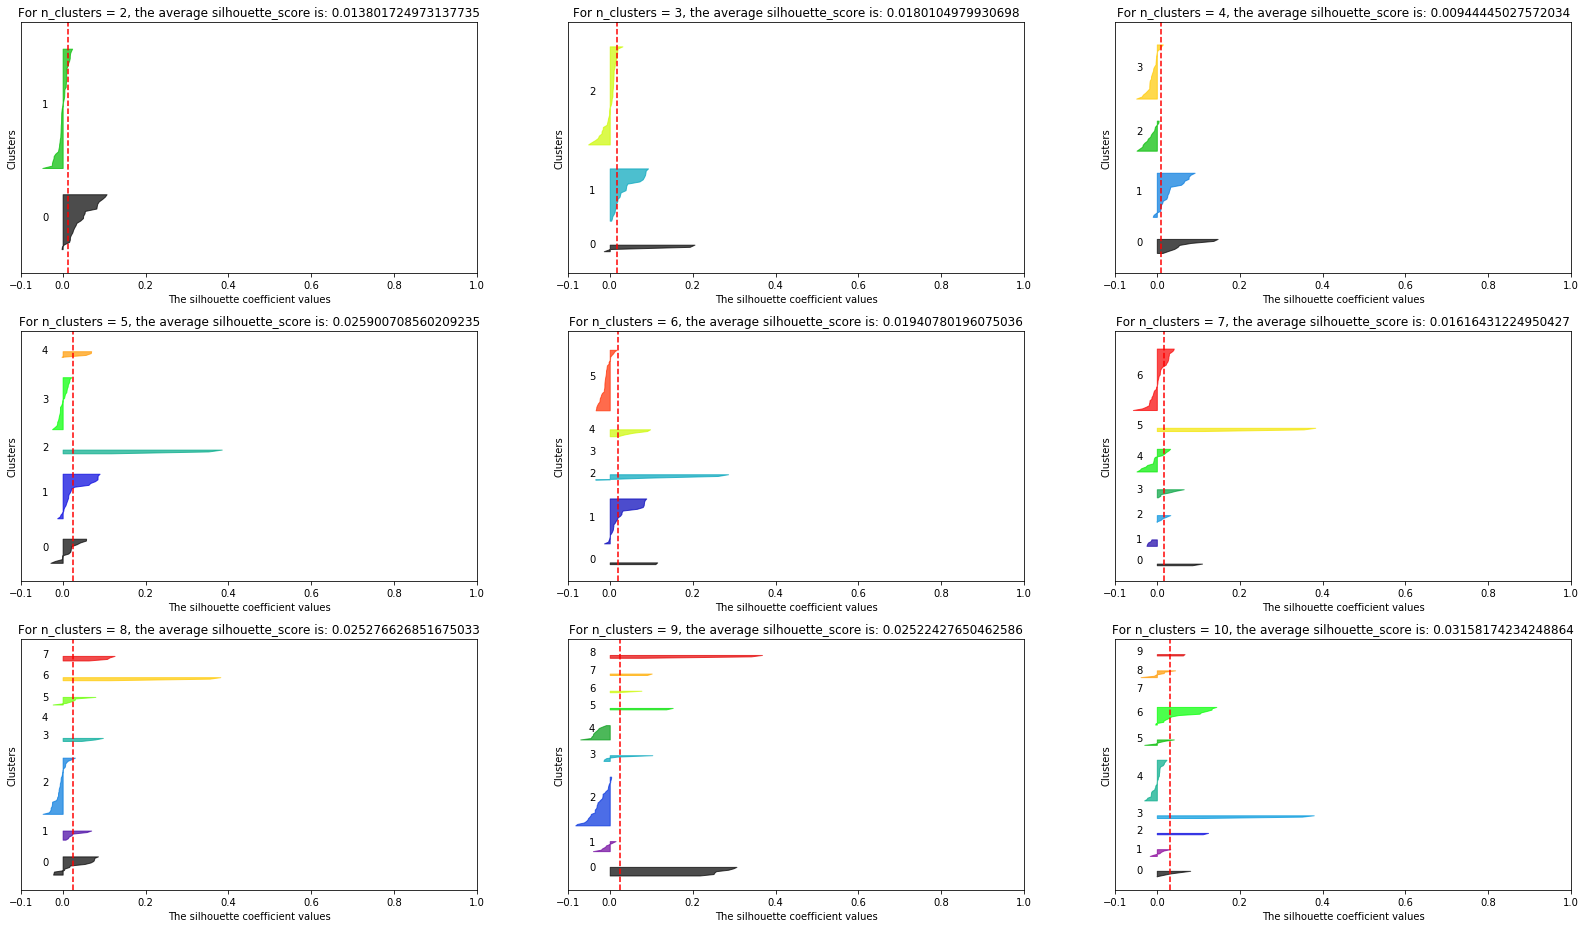

In [284]:
graph_sil_score(dist)

So the silhouette scores are really low (below 0.25) which indicates that the data is not structured. In other words, the clusters will not be well separated when we plot the KMeans clusters in 2-dimensions later on. It seems that KMeans clustering may not be the optimal clustering algorithm for this type of problem, but we'll continue with the analysis to explore the limitations of KMeans. 

Looking at the silhouette scores relative to one another, it appears that the optimal "k" clusters is around 5. 

The elbow method also suggested 5 as one of the optimal number of clusters, further reinforcing the decision to use 5 clusters as "k" for this analysis. 

Again, it will be difficult to make conclusions based on the visuals because the clusters will not be distinct, so we may have to use alternative algorithms to try to make our classifications.

##### Note: we used cosine similarity (dist) to calculate the distance between instances in our feature array. This was used to compute the average silhouette score.

In [285]:
# setting k clusters to 5
num_clusters = 5
km = KMeans(n_clusters=num_clusters,random_state=42)
km.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

## Interpreting the Clusters

Lets try to see if we can see if we can see how the texts and authors were grouped by KMeans. We'll use the information gathered here to make our 2-dimensional visuals.

In [286]:
clusters = km.labels_.tolist() # get the number of clusters from the KMeans model
words = tfidf_v.get_feature_names() # get words (columns) from tfidf matrix

books = {"author":y_train,"book_text":X_train,"cluster":clusters}
frame = pd.DataFrame(books,index=[clusters],columns=["author","book_text","cluster"])
frame.head(3) # primarily concerned with author and cluster

,author,book_text,cluster
1,5,"(0, 6793)\t0.05060558742722204\n (0, 12106)...",1
4,9,"(0, 6793)\t0.05060558742722204\n (0, 12106)...",4
3,15,"(0, 6793)\t0.05060558742722204\n (0, 12106)...",3


In [287]:
# create dictionary of authors by their respective id, used for cluster interpretation
author_id = {}
for author in list(text_df["Author_ID"]):
    if author not in author_id:
        author_id[author] = text_df.loc[text_df["Author_ID"] == author,"Author"].iloc[0]
print("Authors by their ID: \n",author_id)

Authors by their ID: 
 {0: 'Anderson', 1: 'Ashwell', 2: 'Beck', 3: 'Breuer', 4: 'Buckner', 5: 'Budrys', 6: 'Clifton', 7: 'Cogan', 8: 'Del Rey', 9: 'Fyfe', 10: 'Garrett', 11: 'Leiber', 12: 'Reynolds', 13: 'Sentry', 14: 'Wells', 15: 'Williams', 16: 'Zagat'}


In [288]:
# display number of values per cluster
print("Number of values per cluster: \n")
print(frame["cluster"].value_counts())

Number of values per cluster: 

3    29
1    25
0    14
4     4
2     3
Name: cluster, dtype: int64


In [289]:
from __future__ import print_function

print("Authors and top 10 words per cluster: \n")
order_centroids = km.cluster_centers_.argsort()[:,::-1] # sort cluster centers by proximity to centroid
cluster_names = {}

for i in range(num_clusters):
    cluster_names[i] = ""
    print("Cluster %d: "%i)
    print("Top 10 words:")
    for ind in order_centroids[i,:10]:
        cluster_names[i] += ("{} ".format(str(words[ind])))
        print("%s"%words[ind])
    cluster_names[i] = ','.join(cluster_names[i].split())
    print()
    print("Cluster %d authors:"%i,end='')
    for author in frame.loc[i]["author"].values.tolist():
        print(' %s, '%author_id[author],end='')
    print()
    print()

Authors and top 10 words per cluster: 

Cluster 0: 
Top 10 words:
colonel
asteroid
stoker
suit
island
pilot
reactor
rocket
radiation
letter

Cluster 0 authors: Ashwell,  Garrett,  Budrys,  Del Rey,  Garrett,  Garrett,  Leiber,  Williams,  Garrett,  Del Rey,  Anderson,  Williams,  Budrys,  Garrett, 

Cluster 1: 
Top 10 words:
martian
creature
moon
presently
cat
hill
sea
darkness
sphere
rock

Cluster 1 authors: Budrys,  Breuer,  Wells,  Cogan,  Williams,  Leiber,  Williams,  Cogan,  Wells,  Leiber,  Anderson,  Anderson,  Leiber,  Wells,  Zagat,  Fyfe,  Leiber,  Sentry,  Williams,  Reynolds,  Wells,  Anderson,  Wells,  Wells,  Wells, 

Cluster 2: 
Top 10 words:
robot
lop
crowd
scanned
animal
specie
youngster
flower
curb
patrol

Cluster 2 authors: Fyfe,  Garrett,  Leiber, 

Cluster 3: 
Top 10 words:
car
scientist
captain
guy
desk
science
sand
doctor
plane
kid

Cluster 3 authors: Williams,  Reynolds,  Anderson,  Leiber,  Del Rey,  Budrys,  Del Rey,  Anderson,  Clifton,  Clifton,  Budrys,  C

It's interesting how KMeans separated the authors and texts into clusters. Clusters 1 & 4 have the greatest collection of points and, just by looking at the top 10 words, it would seem that the authors chose to use a lot of similar words (primarily names). This would indicate that books from the same genre tend to use similar names for their characters. Also, cluster 2 appears to be consisted of only words from the author Garrett. 

However, we established that KMeans is not a great algorithm for our model because there's no structure in our data. The cluster outcomes could be random and we wouldn't know if what we're seeing are true distinctions between cluster groupings. 

## Visualizing Clusters

Our data is multidimensional (multiple features) so we need to use dimension reduction techniques to reduce the dimension down to 2-dimensions in order to plot on a graph. We'll try using multidimensional scaling (MDS) and t-distributed stochastic neighbor embedding (TSNE) for dimension reduction.

### Multidimensional Scaling (MDS)

MDS is a non-linear dimensionality reduction technique that aims to place each object in N-dimensional space in a way that the distances between the objects is preserved as well as possible. 

In [290]:
from sklearn.manifold import MDS

mds = MDS(n_components = 2, dissimilarity = "precomputed", random_state = 42)
pos = mds.fit_transform(dist) # shape (n_components,n_samples)

In [291]:
xs,ys = pos[:,0],pos[:,1]

In [292]:
# set up colors per cluster (store in dictionary)
cluster_colors = {0:"#ffe059",1:"#9cff07",2:"#ff0707",3:"#07ffc1",4:"#a407ff"}

In [293]:
df = pd.DataFrame(dict(x=xs,y=ys,label=clusters,author= [author_id[i] for i in y_train]))
groups = df.groupby('label')
df.head(3)

,x,y,label,author
0,0.756527,-0.059041,1,Budrys
1,-0.275753,0.636193,4,Fyfe
2,-0.739567,-0.165282,3,Williams


/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


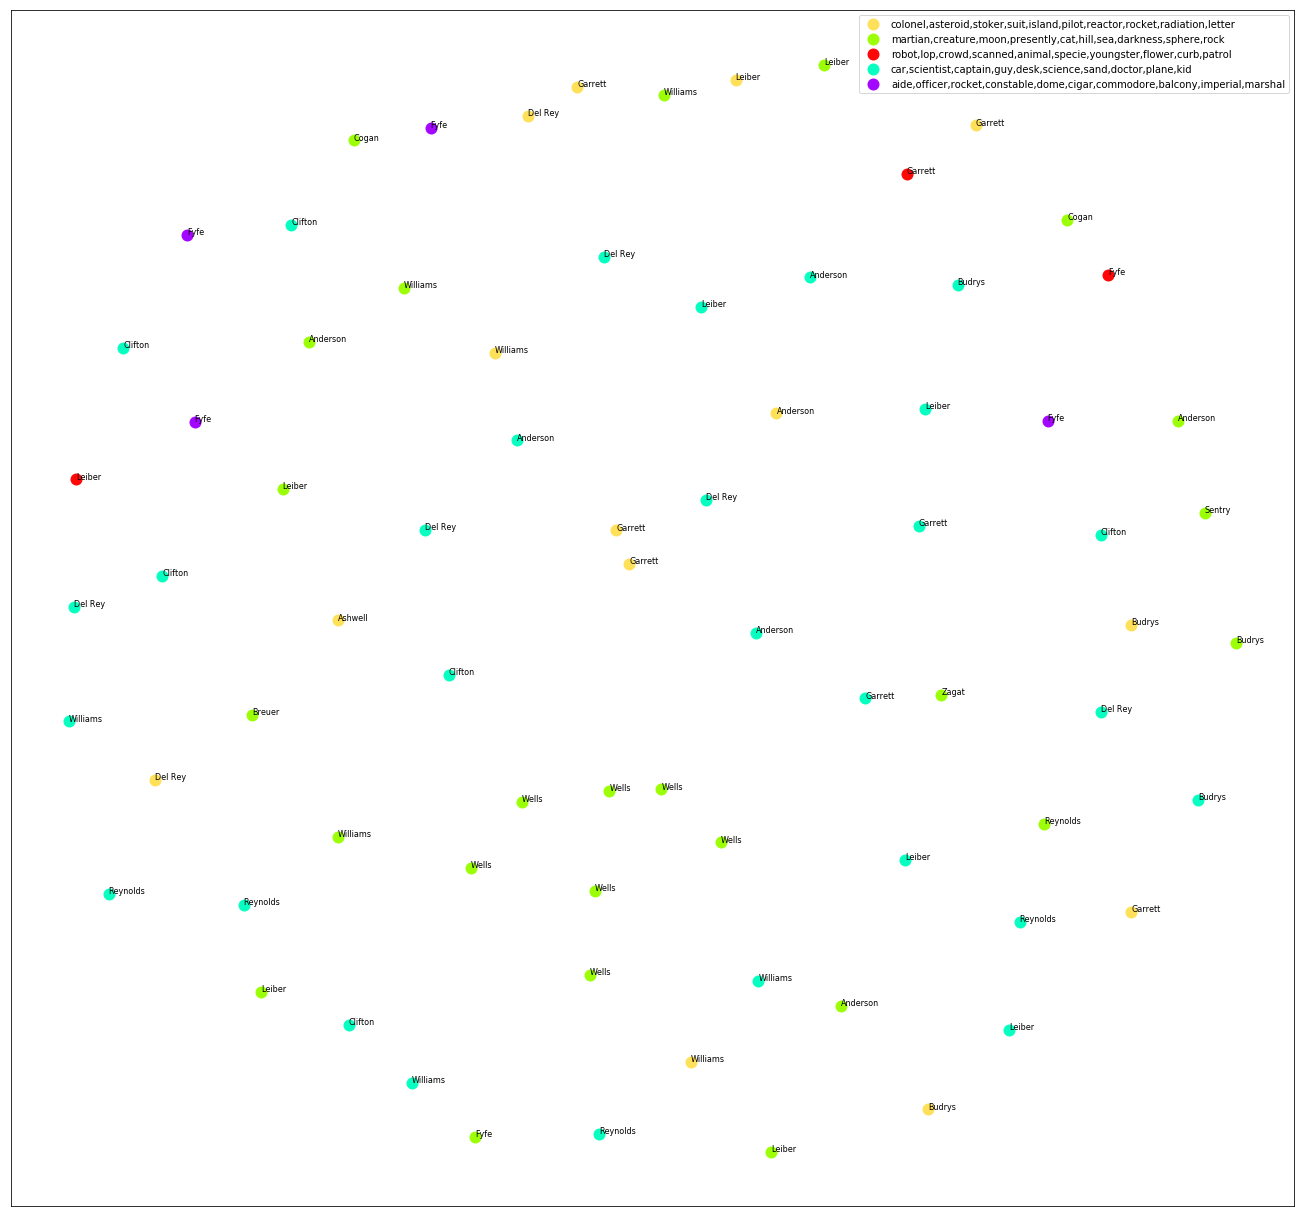

In [294]:
# plot the MDS reduced data
fig, ax = plt.subplots(figsize=(23,22))

for name,group in groups:
    ax.plot(group.x,group.y,marker='o',linestyle='',ms=12,
            label=cluster_names[name],color=cluster_colors[name],mec="none")
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='False',    # ticks along the bottom edge are off
        top='False',       # ticks along the top edge are off
        labelbottom='False')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='False',      # ticks along the bottom edge are off
        top='False',       # ticks along the top edge are off
        labelleft='False')
    ax.legend(numpoints=1) # show legend with only 1 point

for i in range(len(df)):
    ax.text(df.loc[i]['x'],df.loc[i]['y'],df.loc[i]['author'],size=8)

plt.show()

### T-distributed stochastic neighbor embedding (TSNE)

A nonlinear dimensionality reduction technique that models each high-dimensional object by a two or three dimensional point in a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. This minimizes the divergence between two distributions.

In [295]:
from sklearn.manifold import TSNE
tfs_embedded = TSNE(n_components = 2, perplexity =40, init="pca", n_iter=2500, verbose=2,random_state = 42).fit_transform(X_train.toarray())

[t-SNE] Computing 74 nearest neighbors...
[t-SNE] Indexed 75 samples in 0.002s...
[t-SNE] Computed neighbors for 75 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 75 / 75
[t-SNE] Mean sigma: 0.279727
[t-SNE] Computed conditional probabilities in 0.005s
[t-SNE] Iteration 50: error = 65.9382629, gradient norm = 0.4890373 (50 iterations in 0.049s)
[t-SNE] Iteration 100: error = 64.4221115, gradient norm = 0.3954947 (50 iterations in 0.053s)
[t-SNE] Iteration 150: error = 62.0731926, gradient norm = 0.5385833 (50 iterations in 0.059s)
[t-SNE] Iteration 200: error = 59.5352020, gradient norm = 0.3753522 (50 iterations in 0.051s)
[t-SNE] Iteration 250: error = 57.9771309, gradient norm = 0.4637692 (50 iterations in 0.050s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.977131
[t-SNE] Iteration 300: error = 1.0960129, gradient norm = 0.0017166 (50 iterations in 0.049s)
[t-SNE] Iteration 350: error = 0.8849196, gradient norm = 0.0019915 (50 i

In [296]:
tsne_group = pd.DataFrame(tfs_embedded,columns=['x','y']).assign(category=y_train).groupby('category')

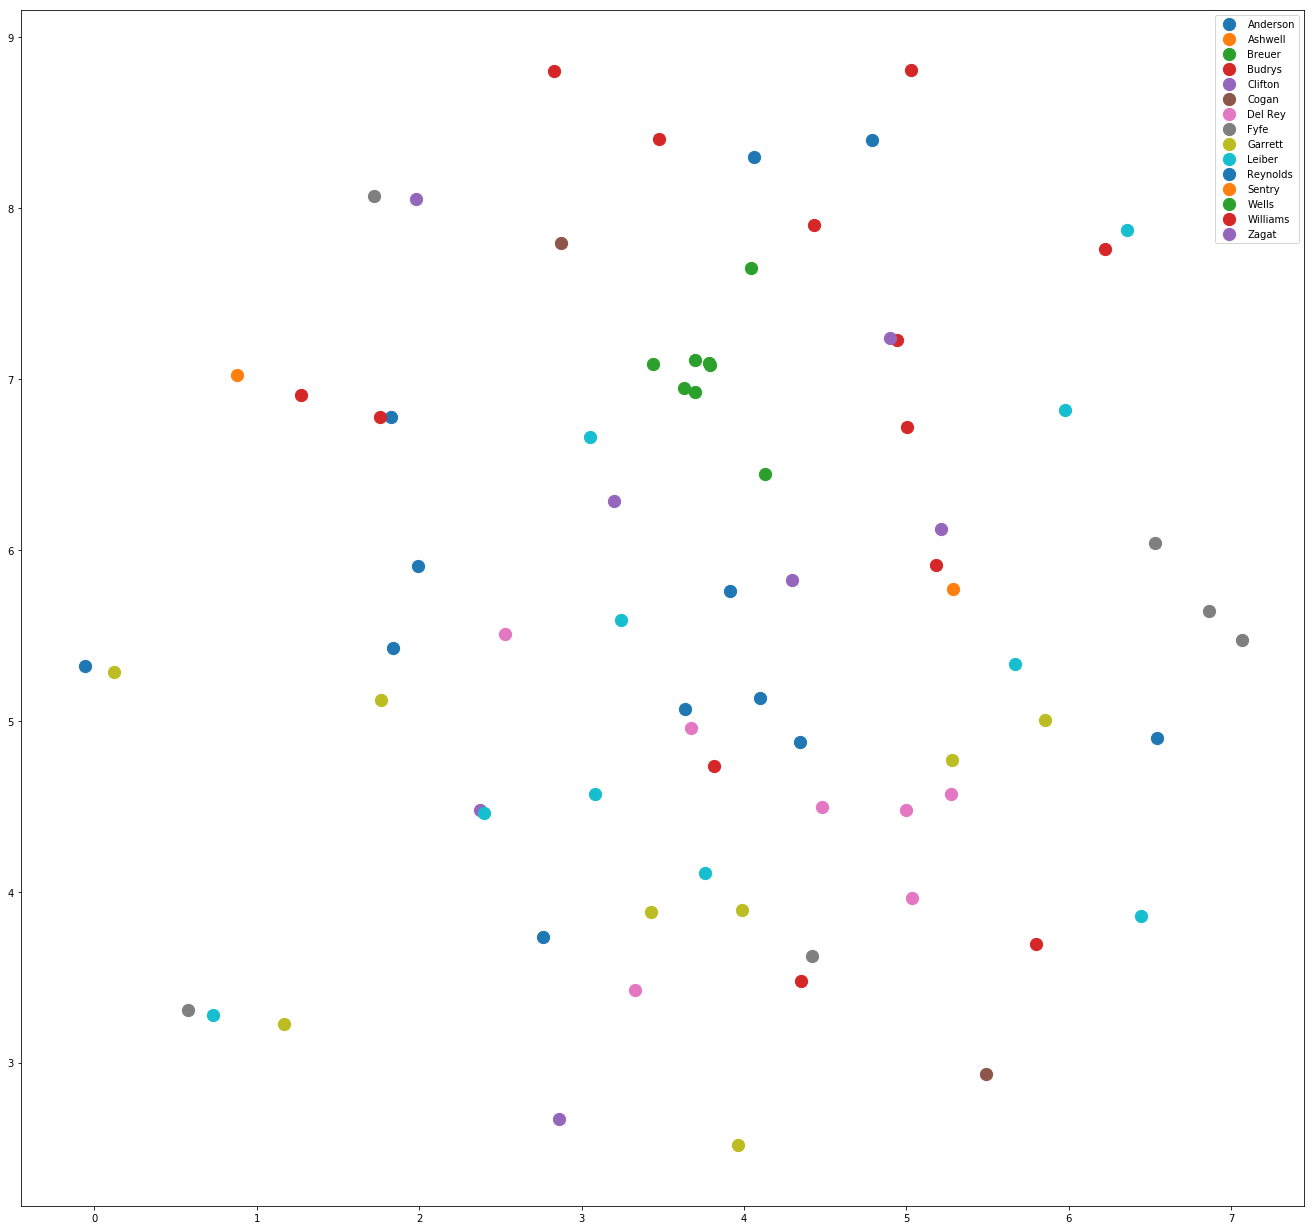

In [297]:
fig,ax = plt.subplots(figsize=(23,22))

for name,points in tsne_group:
    ax.scatter(points.x,points.y,label=author_id[name],s=150)

ax.legend()
plt.show()

As we can see from the two cluster visuals, there is little distinctions between the clusters. There appears to be some cluster groupings, but some points are indicated as having membership to certain clusters even though they appear to be closer to other cluster groupings. We are prepared for this outcome because we determined that our data has no structure based on our findings in determining the optimal number of clusters for our KMeans model. 

This is not to say that the KMeans algorithm is faulty, but instead that the objective for the project was not defined in such a way to take advantage of KMeans stronger attributes. Attempting to classify books from the same genre by author based on the similarity between texts is very difficult. Books from the same genre, and perhaps the same time period, utilize many similar properties (i.e. character names, plots, adjectives, etc.). This makes sense since they were grouped into the genre based on the context of the plot which is composed of certain distinct wording. 

So maybe using KMeans wasn't the best approach to this problem. Lets try a different approach using a different model...

## Hierarchical Clustering

A clustering technique that initially separates each observation into a distinct cluster. It then identifies two clusters that are closest together and merges the two most similar clusters. This process continues until all clusters are merged together. The visual output is considered a dendrogram and it represents the hierarchical relationship between clusters. 

In this analysis, we will be using the ward clustering algorithm because it utilizes an agglomerative hierarchical clustering method. The agglomerative method is a bottom up approach where each observation starts in its own cluster and pairs of clusters are merged as we move up the hierarchy. The cluster groupings will be highlighted by color. 

/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


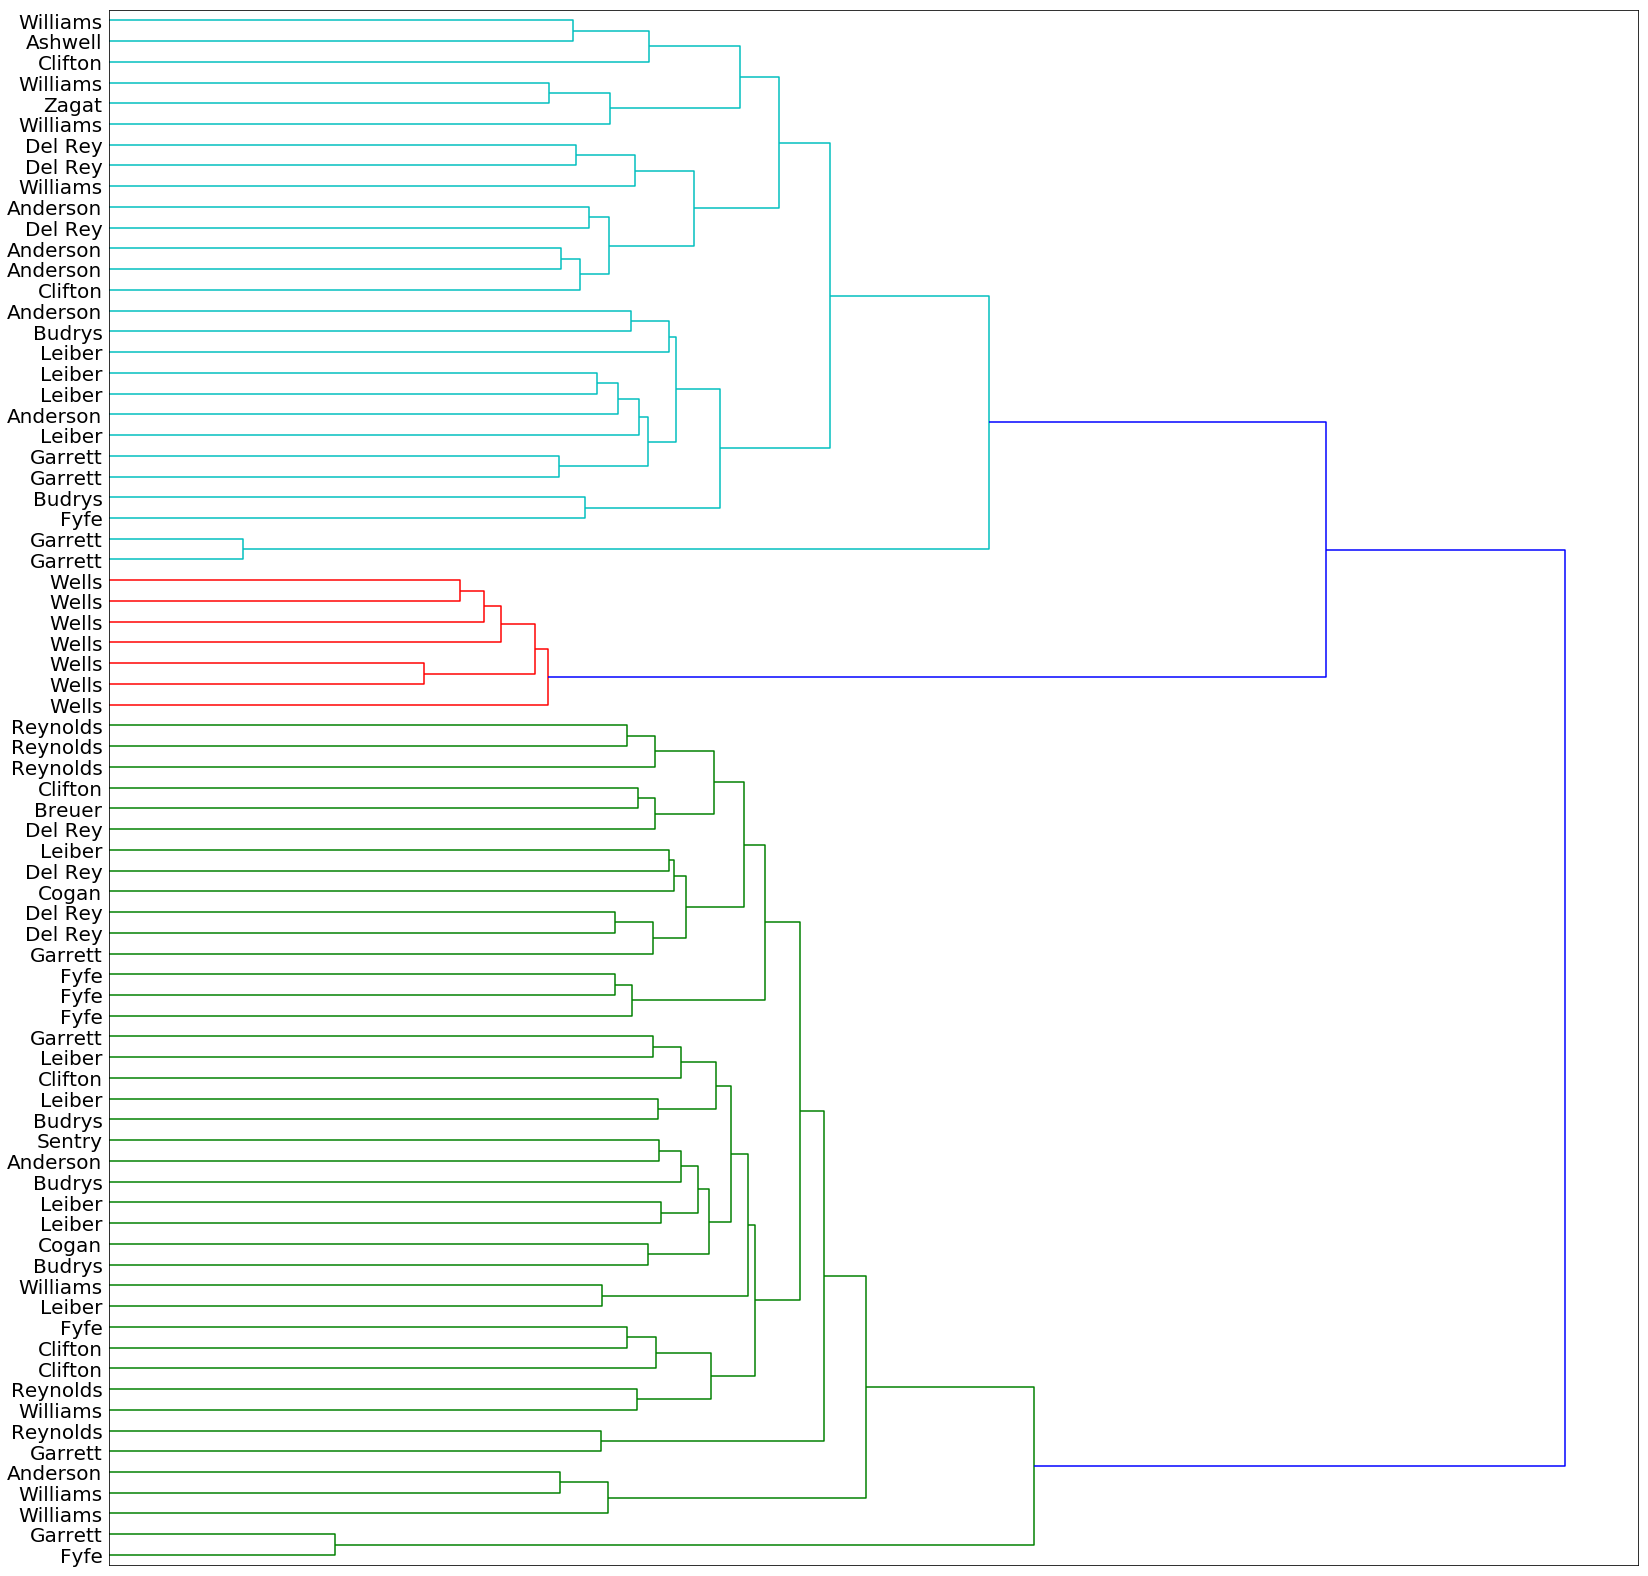

In [298]:
from scipy.cluster.hierarchy import ward,dendrogram

linkage_matrix = ward(dist)

fig,ax = plt.subplots(figsize=(23,22)) 

ax = dendrogram(linkage_matrix,orientation="right",labels=[author_id[i] for i in y_train])

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='False',      # ticks along the bottom edge are off
    top='False',         # ticks along the top edge are off
    labelbottom='False'
)

plt.tick_params(labelsize=20)
plt.tight_layout()

Now this looks much better! The different colors indicate 3 primary clusters. Within each cluster it appears that the ward clustering algorithm is pairing the authors accurately (i.e. text cluster from Fyfe is paired with text cluster from another Fyfe text cluster). There is still some pairings that are off, but that could indicate that the texts from different authors are more alike than texts from different books from the same author. 

This is a better approach for visualizing our data than KMeans, so lets see how the visual looks with our test data. 

## Making clusters using test set

The purpose of this visual is to see if the hierarchical clustering technique performs similar to our holdout (test) group when compared to our training group.

In [299]:
dist_test = 1 - cosine_similarity(X_test)

/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


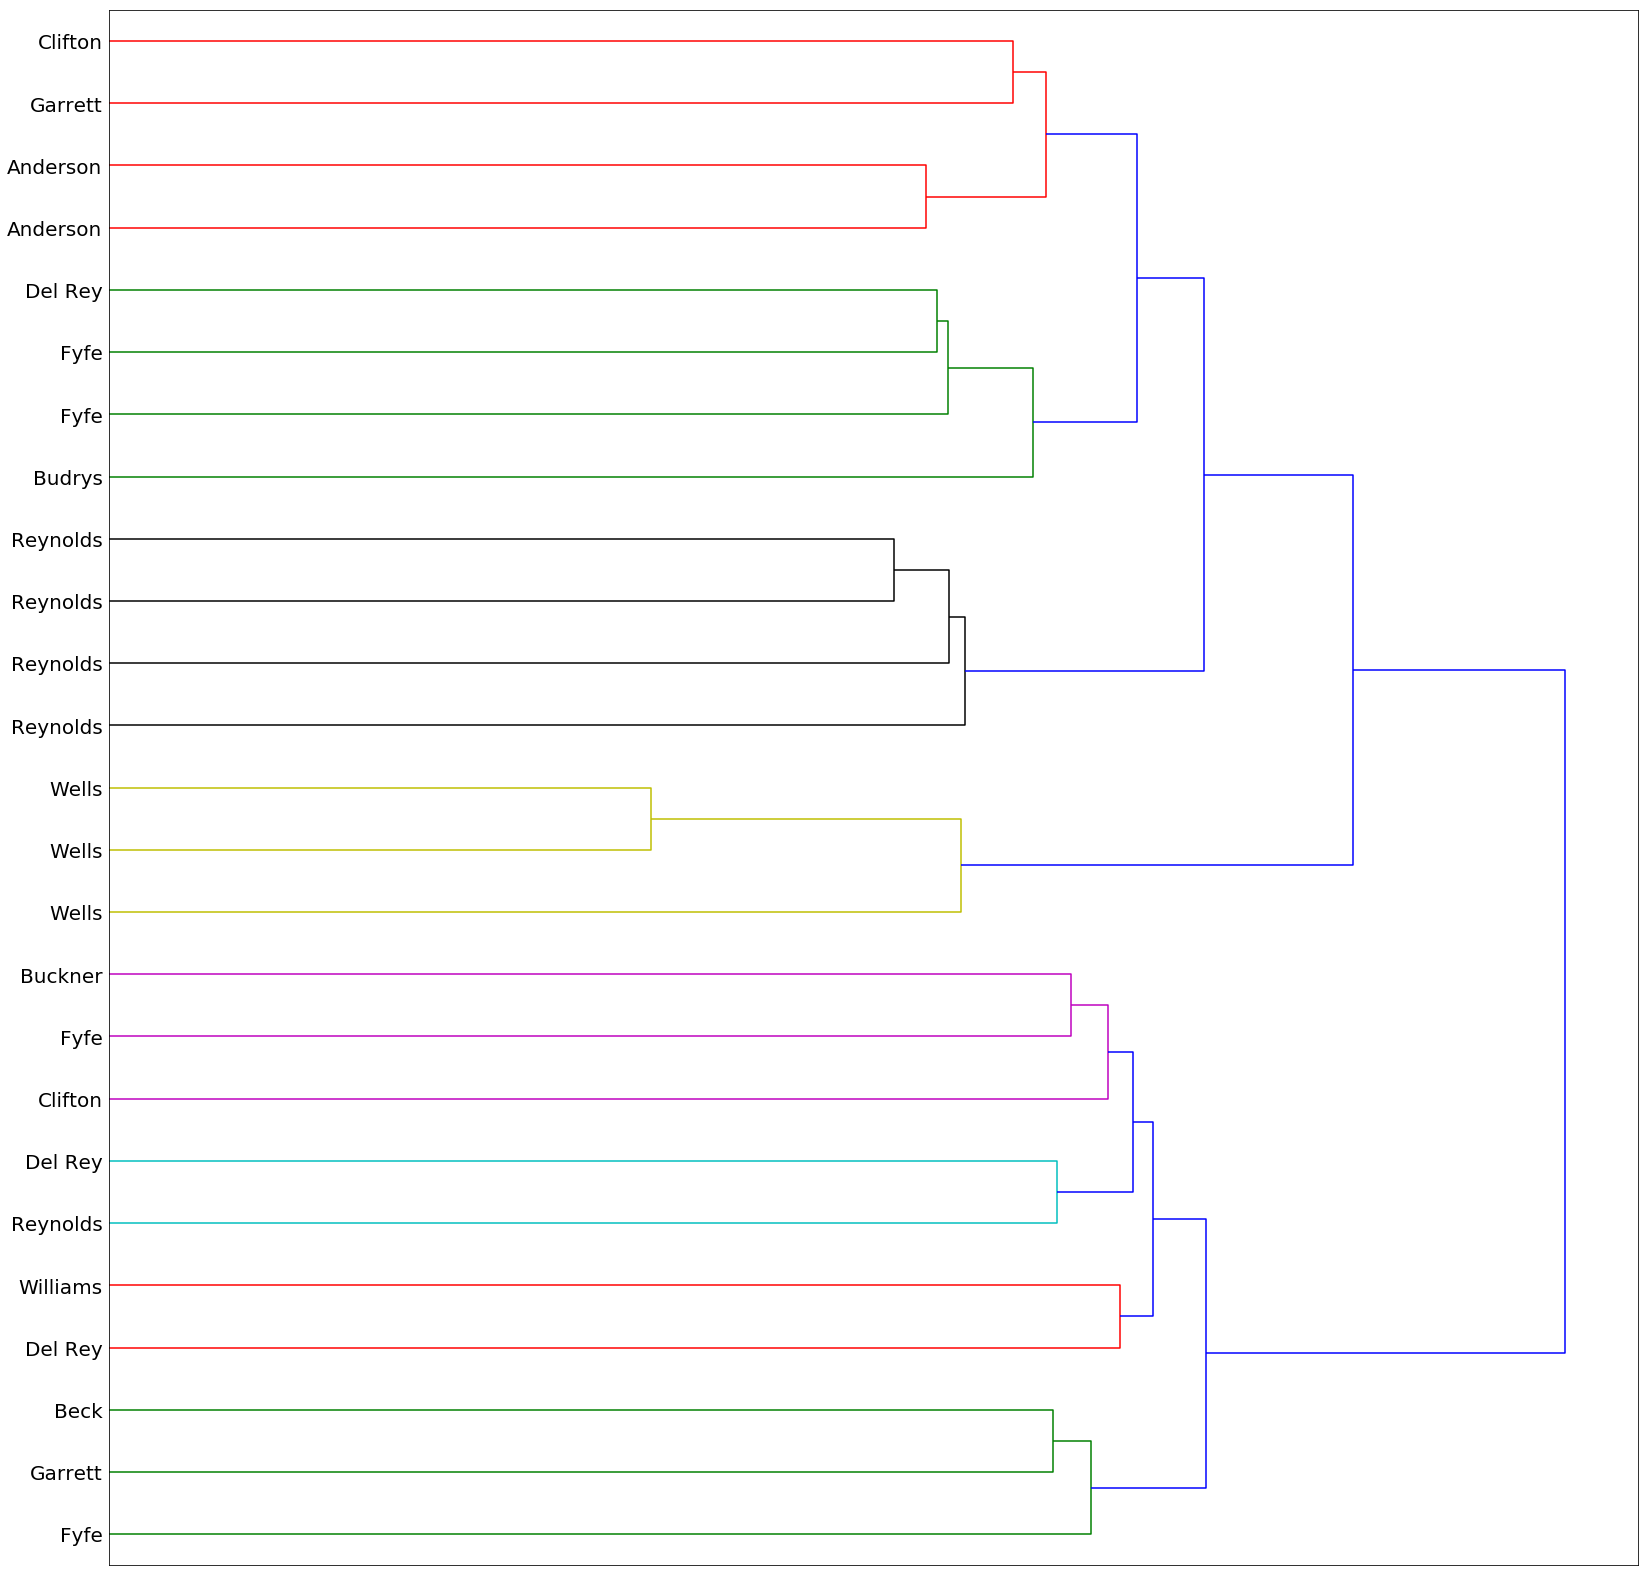

In [300]:
linkage_matrix_test = ward(dist_test)

fig,ax = plt.subplots(figsize=(23,22)) 

ax = dendrogram(linkage_matrix_test,orientation="right",labels=[author_id[i] for i in y_test])

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='False',      # ticks along the bottom edge are off
    top='False',         # ticks along the top edge are off
    labelbottom='False'
)

plt.tick_params(labelsize=20)
plt.tight_layout()

According to the plot, there appears to be 7 primary clusters, and the groupings appear to be less accurate than the our previous plot. There are two clusters that consist of 1 author while others are a mix of multiple authors. This could be due to having a smaller variety of text in the test set than the training set, which would translate to limited variety for the clustering algorithm to draw similarities between texts to accurately classify the respective author.

The plot does accurately group text from Wells like the previous plot. This could indicate a unique writing style or text content that consistently distinguishes Wells books from the rest of the authors.

## Conclusion

We explored some unsupervised learning techniques while attempting to classify a selection of book texts by their respective authors. We considered using KMeans clusters because we thought that we could distinguish the texts based on similarity and create distinctive clusters.

Turns out that the texts were too similar to each other, meaning that the data was mostly spread out evenly with no apparent concentrations of points to certain clusters. This is most likely due to the fact that the books were of the same genre and written around the same time period. So some words appeared across multiple texts and therefore our KMeans approach produced a very congested cluster plot with very little distinction between the 5 clusters we chose to implement. 

We did improve the model slightly by later removing the proper nouns (i.e. names, titles, etc.) which were abundant in the top words picked up by the clusters. By allowing the model to focus on other more distinguishing words, we were able to get some form of cluster groupings.

We also utilized the agglomerative hierarchical clustering approach which produced more distinctive clusters and grouped authors more accurately than KMeans. This is probably due to the algorithm taking each object as a distinct cluster and then making comparisons from there to create cluster groupings. For the KMeans approach, it was difficult to determine where to begin and when to stop in order to find the optimal number of clusters. For this reason, we could have chosen the wrong number of clusters or it might be the case that there are no optimal clusters for KMeans in terms of our chosen dataset. 

We also learned more about some other non-linear dimension reduction techniques besides PCA that can be used in situations where the data is sparsely distributed. I found the TSNE method to be interesting since it used PCA in conjunction with probability to model high dimension data by similarity. 

## Improvement Suggestions

While the unsupervised learning methods used in this analysis were very interesting and informative, there is much room for improvement. Some suggestions would be:

1. Pick books from different genres with different authors, just in case an author has books in multiple genres

2. Try to balance out the number of books per author, some authors had only 1 book whereas others had 8 to 10 books.

3. Try using a different algorithm (spectral clustering) or neural network (word2vec) 

4. Try using supervised learning model in conjunction with unsupervised learning clusters

5. Change the target variable from authors to classifying books by genre or rating

In [301]:
# remove warning messages from notebook
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')